In [4]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from Gaussian_wavelet import GaussSigmoid as gs
from scipy.stats import qmc
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
np.random.seed(42)
torch.manual_seed(42)
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 20)   # Input: x and t
        self.hidden2 = nn.Linear(20, 20)
        self.hidden3 = nn.Linear(20, 20)
        #self.hidden4 = nn.Linear(20, 20)
        #self.hidden5 = nn.Linear(20, 20)
        #self.hidden6 = nn.Linear(20, 20)
        self.output = nn.Linear(20, 1)    # Output: [x(t), y(t)]
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(1.0))
        self.c = nn.Parameter(torch.tensor(1.0))
        self.act = gs()
        #self.d = nn.Parameter(torch.tensor(1.0))
        #self.e = nn.Parameter(torch.tensor(1.0))
        #self.f = nn.Parameter(torch.tensor(1.0))

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)  # Combine x and t into a single tensor
        h1 = torch.erf(self.a * self.hidden1(inputs))  # Apply erf
        h2 = torch.erf(self.b * self.hidden2(h1))
        h3 = torch.erf( self.c * self.hidden3(h2))
        #h4 = torch.erf(3 * self.d * self.hidden4(h3))
        #h5 = torch.erf(3 * self.e * self.hidden5(h4))
        #h6 = torch.erf(3 * self.f * self.hidden6(h5))
        output = self.output(h3)
        return output


# Physics-Informed Neural Network loss function for y_xx + π²*sin(πx) = 0
def pinn_loss(model,x, t):
    # x requires_grad is set before calling this function
    x.requires_grad = True
    t.requires_grad = True
    output = model(x,t)


    u_x = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True,retain_graph =True)[0]
    u_t = torch.autograd.grad(output, t, grad_outputs=torch.ones_like(output), create_graph=True,retain_graph =True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True,retain_graph =True)[0]

    # PDE residual: x_t + 2x +y = 0
    residual1 = u_t - u_xx

    return torch.mean(residual1**2)



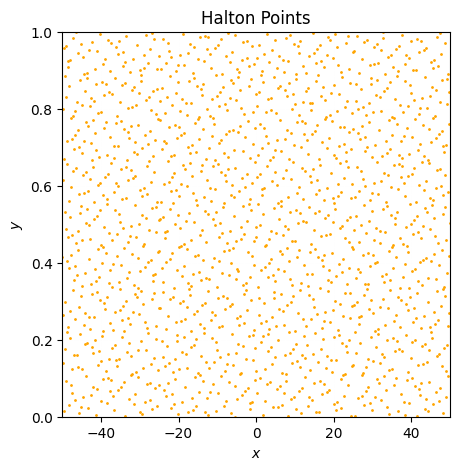

In [5]:
# Plot to visualize
N = 1500
sampler = qmc.Halton(d=2, scramble=True)
points = sampler.random(n=N)

# Convert to torch
x_train = torch.tensor(points[:, 0] * 100 -50, dtype=torch.float32).view(-1, 1)
t_train = torch.tensor(points[:, 1], dtype=torch.float32).view(-1, 1)
plt.figure(figsize=(5, 5))  # Make it square for better visualization
plt.scatter(x_train, t_train, s=1,color='orange')
plt.title("Halton Points")
plt.xlim(-50, 50)
plt.ylim(0, 1)
#plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True, linestyle='--', alpha=0.01)
plt.savefig("Heat Equation discontinuous col1.png", dpi=300)
plt.show()


In [6]:

def u_exact(x, t):
    return 0.5 - 0.5*torch.erf(x/(torch.sqrt(4*t)))
def u0_exact(x):
    return torch.where(x> 0,torch.tensor(0.0),torch.tensor(1.0))
# Generate training data
def generate_training_data(N_f=1500):
    sampler = qmc.Halton(d=2, scramble=True)
    points = sampler.random(n=N_f)

    # Convert to torch
    x_f =(-50 + 100*torch.tensor(points[:, 0], dtype=torch.float32,device=device)).reshape(-1, 1)
    t_f = torch.tensor(points[:, 1], dtype=torch.float32, device=device).reshape(-1, 1)
    x_l = -50 *  torch.ones(200,1, dtype=torch.float32, device=device)
    t_rand = torch.rand(200,1, dtype=torch.float32, device=device)

    x_r =   torch.ones(200,1, dtype=torch.float32, device=device) * 50
    x_rand = torch.rand(300,1, dtype=torch.float32, device=device) * 100 -50
    t_i = torch.zeros(300,1, dtype=torch.float32, device=device)
    # Generate Halton points
    return x_f, t_f, x_l, t_rand, x_r,x_rand , t_i

# Define loss function
def compute_loss(model, x_f, t_f, x_l, t_rand,x_r, x_rand , t_i):
    # boundary conditions for left boundary
    pred_xl = model(x_l, t_rand)
    exact_xl = torch.ones_like(pred_xl)
    loss_xl = torch.mean((pred_xl - exact_xl)** 2)

    # boundary conditions for right boundary
    pred_xr = model(x_r, t_rand)
    exact_xr = torch.zeros_like(pred_xr)
    loss_xr = torch.mean((pred_xr - exact_xr)** 2)

    # Initial Conditions
    pred_u0 = model(x_rand, t_i)
    exact_u0 = u0_exact(x_rand)
    int_loss = torch.mean((pred_u0 - exact_u0)** 2)

    # Physics loss
    pde_loss = pinn_loss(model, x_f, t_f)
    bd_loss = (loss_xl + loss_xr)
    # Combine all losses - adjust weights as needed
    total_loss =  bd_loss +  pde_loss + int_loss

    return total_loss , pde_loss , bd_loss, int_loss



In [7]:
# PART 6: TRAINING LOOP WITH MONITORING
###########################################
# Create model with deeper architecture
model =  PINN().to(device)

# Two-stage optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

# Cyclic learning rate scheduler with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1000, T_mult=2, eta_min=1e-5
)

# Generate training data using Halton sequences
print("Generating training data with Halton sequences...")
(x_f, t_f, x_l, t_rand, x_r,x_rand , t_i) = generate_training_data()

# Progressive training with dynamic weighting
print("Starting training...")
start_time = time.time()
loss_history = []
pde_loss_history = []
bc_loss_history = []
ic_loss_history = []

# Create a second optimizer with higher learning rate for fine-tuning
optimizer_fine = optim.LBFGS(model.parameters(), lr=0.1, max_iter=20,
                            history_size=50, tolerance_grad=1e-8,
                            tolerance_change=1e-10, line_search_fn="strong_wolfe")

# First stage: Adam optimizer with dynamic weighting
epochs = 15000  # Increased epochs for better convergence
best_loss = float('inf')
best_model_state = None
patience_counter = 0
max_patience = 10  # Early stopping patience

# Define weights for loss components that will change over time
pde_weight = 1.0
bc_weight = 10.0  # Start with higher weight on boundary conditions
ic_weight = 10.0  # Start with higher weight on initial conditions

for epoch in range(epochs):
    # Update weights based on training progress
    if epoch % 2000 == 0 and epoch > 0:
        bc_weight = max(1.0, bc_weight * 0.5)  # Gradually reduce BC weight
        ic_weight = max(1.0, ic_weight * 0.5)  # Gradually reduce IC weight
        pde_weight = min(10.0, pde_weight * 1.5)  # Gradually increase PDE weight

    # Clear gradients
    optimizer.zero_grad()

    # Compute loss components
    total_loss , pde_loss , bd_loss, int_loss= compute_loss(
        model, x_f, t_f, x_l, t_rand, x_r,x_rand , t_i)

    # Apply dynamic weighting
    loss = pde_weight * pde_loss + bc_weight * bd_loss + ic_weight * int_loss
    loss.backward()

    # Gradient clipping with adaptive threshold
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

    # Update parameters and learning rate
    optimizer.step()
    scheduler.step()

    # Store loss history
    loss_value = loss.item()
    loss_history.append(loss_value)
    pde_loss_history.append(pde_loss.item())
    bc_loss_history.append(bd_loss.item())
    ic_loss_history.append(int_loss.item())

    # Check for best model
    if loss_value < best_loss:
        best_loss = loss_value
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping with patience
    if patience_counter > max_patience and epoch > 8000:
        print(f"Early stopping at epoch {epoch} due to no improvement")
        break

    # Print progress
    if epoch % 500 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch}/{epochs} - Time: {elapsed:.2f}s")
        print(f"  Total Loss: {loss_value:.8f}")
        print(f"  PDE Loss: {pde_loss.item():.8f} (weight: {pde_weight:.2f})")
        print(f"  BC Loss: {bd_loss.item():.8f} (weight: {bc_weight:.2f})")
        print(f"  IC Loss: {int_loss.item():.8f} (weight: {ic_weight:.2f})")
        print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.8f}")

# Load best model from Adam optimization
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with loss: {best_loss:.8f}")

# Second stage: L-BFGS fine-tuning
print("\nStarting L-BFGS fine-tuning...")

# L-BFGS requires a closure function
def closure():
    optimizer_fine.zero_grad()
    loss, pde_loss, bd_loss, int_loss = compute_loss(
        model,x_f, t_f, x_l, t_rand, x_r,x_rand , t_i)
    # Equal weighting for fine-tuning
    loss = pde_loss + bd_loss + int_loss
    loss.backward()
    return loss

# Run L-BFGS for fine-tuning
for i in range(5):  # Multiple L-BFGS runs
    loss = optimizer_fine.step(closure)
    print(f"L-BFGS step {i+1}, Loss: {loss.item():.8f}")

print(f"Training completed in {time.time() - start_time:.2f} seconds")

print(f"Training completed in {time.time() - start_time:.2f} seconds")

###########################################
# After training completes (before plotting)
save_path = 'heat_equation discontinuous path1.pt'
torch.save({
    'model_state': model.state_dict(),
    'config': {
        'hidden_layers': [20, 20, 20],
        'activation': 'erf',
        'input_dim': 2,
        'output_dim': 1
    }
}, save_path)
print(f"Model saved to {save_path}")

Generating training data with Halton sequences...
Starting training...
Epoch 0/15000 - Time: 0.13s
  Total Loss: 26.34543991
  PDE Loss: 0.00038253 (weight: 1.00)
  BC Loss: 1.77973652 (weight: 10.00)
  IC Loss: 0.85476911 (weight: 10.00)
  Learning rate: 0.00100000
Epoch 500/15000 - Time: 15.68s
  Total Loss: 0.02062922
  PDE Loss: 0.00312420 (weight: 1.00)
  BC Loss: 0.00002244 (weight: 10.00)
  IC Loss: 0.00172806 (weight: 10.00)
  Learning rate: 0.00050344
Epoch 1000/15000 - Time: 33.89s
  Total Loss: 0.01635324
  PDE Loss: 0.00278610 (weight: 1.00)
  BC Loss: 0.00000000 (weight: 10.00)
  IC Loss: 0.00135671 (weight: 10.00)
  Learning rate: 0.00100000
Epoch 1500/15000 - Time: 47.40s
  Total Loss: 0.00876544
  PDE Loss: 0.00123852 (weight: 1.00)
  BC Loss: 0.00011805 (weight: 10.00)
  IC Loss: 0.00063464 (weight: 10.00)
  Learning rate: 0.00085447
Epoch 2000/15000 - Time: 59.44s
  Total Loss: 0.00254622
  PDE Loss: 0.00063647 (weight: 1.50)
  BC Loss: 0.00007747 (weight: 5.00)
  IC 

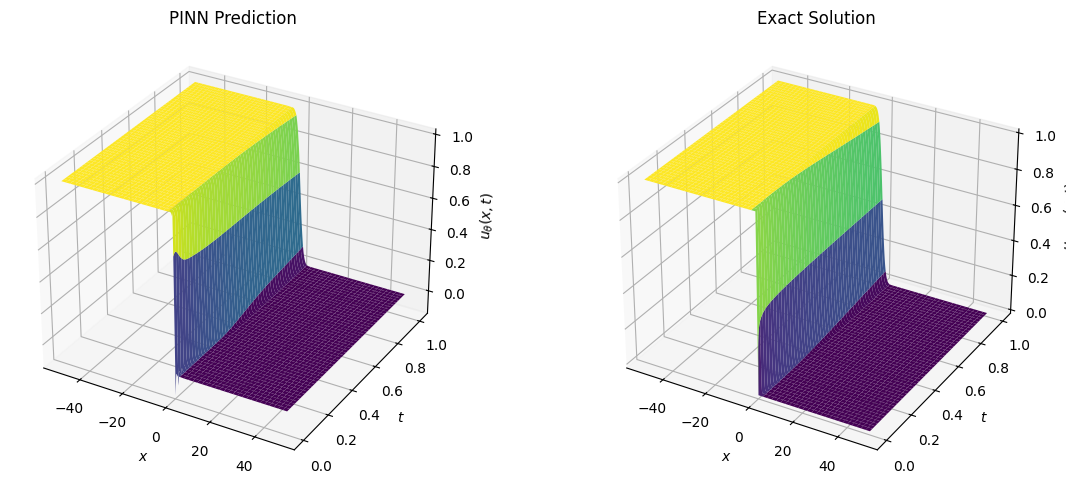

In [8]:
# Load the saved model correctly
saved_data = torch.load('heat_equation discontinuous path1.pt') # Corrected line


# Approach 1: Extract model_state first
if 'model_state' in saved_data:
    model = PINN().to(device)
    model.load_state_dict(saved_data['model_state'])
    model.eval()
else:
    print("Different structure than expected. Keys found:", saved_data.keys())

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid for plotting
x_vals = torch.linspace(-50, 50, 1000).view(-1, 1)
t_vals = torch.linspace(0, 1, 1000).view(-1, 1)
X, T = torch.meshgrid(x_vals.squeeze(), t_vals.squeeze(), indexing='ij')

# Flatten and send to device
x_plot = X.reshape(-1, 1).to(device)
t_plot = T.reshape(-1, 1).to(device)

# Evaluate model and exact solution
with torch.no_grad():
    U_pred = model(x_plot, t_plot).cpu().numpy().reshape(1000, 1000)
    U_exact = u_exact(x_plot, t_plot).cpu().numpy().reshape(1000, 1000)

# Convert meshgrid to numpy for plotting
X_np = X.cpu().numpy()
T_np = T.cpu().numpy()

# Plot side-by-side
fig = plt.figure(figsize=(12, 5))

# PINN Prediction
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X_np, T_np, U_pred, cmap='viridis')
ax1.set_title('PINN Prediction')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$t$')
ax1.set_zlabel('$u_\\theta(x,t)$')

# Exact Solution
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X_np, T_np, U_exact, cmap='viridis')
ax2.set_title('Exact Solution')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$t$')
ax2.set_zlabel('$u_{\\text{exact}}(x,t)$')
plt.savefig('PINN_vs_Exact_Hheat_discontinuous1.png',dpi = 300)
plt.tight_layout()
plt.show()


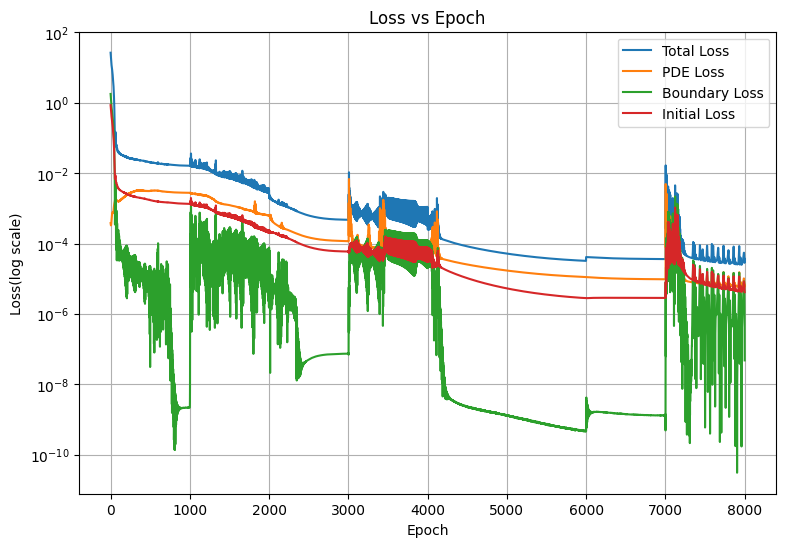

In [9]:
# Plot for loss
plt.figure(figsize=(9, 6))
# Plot the loss history lists instead of the last tensor values
plt.semilogy(loss_history, label='Total Loss')
plt.semilogy(pde_loss_history, label='PDE Loss')
plt.semilogy(bc_loss_history, label='Boundary Loss')
plt.semilogy(ic_loss_history, label='Initial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss(log scale)')
plt.title('Loss vs Epoch')
plt.grid(True)
plt.legend() # Add a legend to identify the curves
plt.savefig('Heat equation discontinuous1 loss.png',dpi=300)
plt.show()

In [10]:
def calculate_l2_errors(model):
    x = torch.linspace(-50, 50, 1000, device=device)
    t = torch.linspace(0, 1, 1000, device=device)
    X, T = torch.meshgrid(x, t)

    with torch.no_grad():
        U_pred = model(X.reshape(-1, 1), T.reshape(-1, 1))
        U_exact = u_exact(X.reshape(-1, 1), T.reshape(-1, 1))

    l2_error = torch.sqrt(torch.mean((U_pred - U_exact)**2))
    max_error = torch.max(torch.abs(U_pred - U_exact))

    print(f"Global L2 Error: {l2_error.item():.4e}")
    print(f"Maximum Pointwise Error: {max_error.item():.4e}")

calculate_l2_errors(model)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Global L2 Error: 1.9923e-02
Maximum Pointwise Error: 7.3919e-01


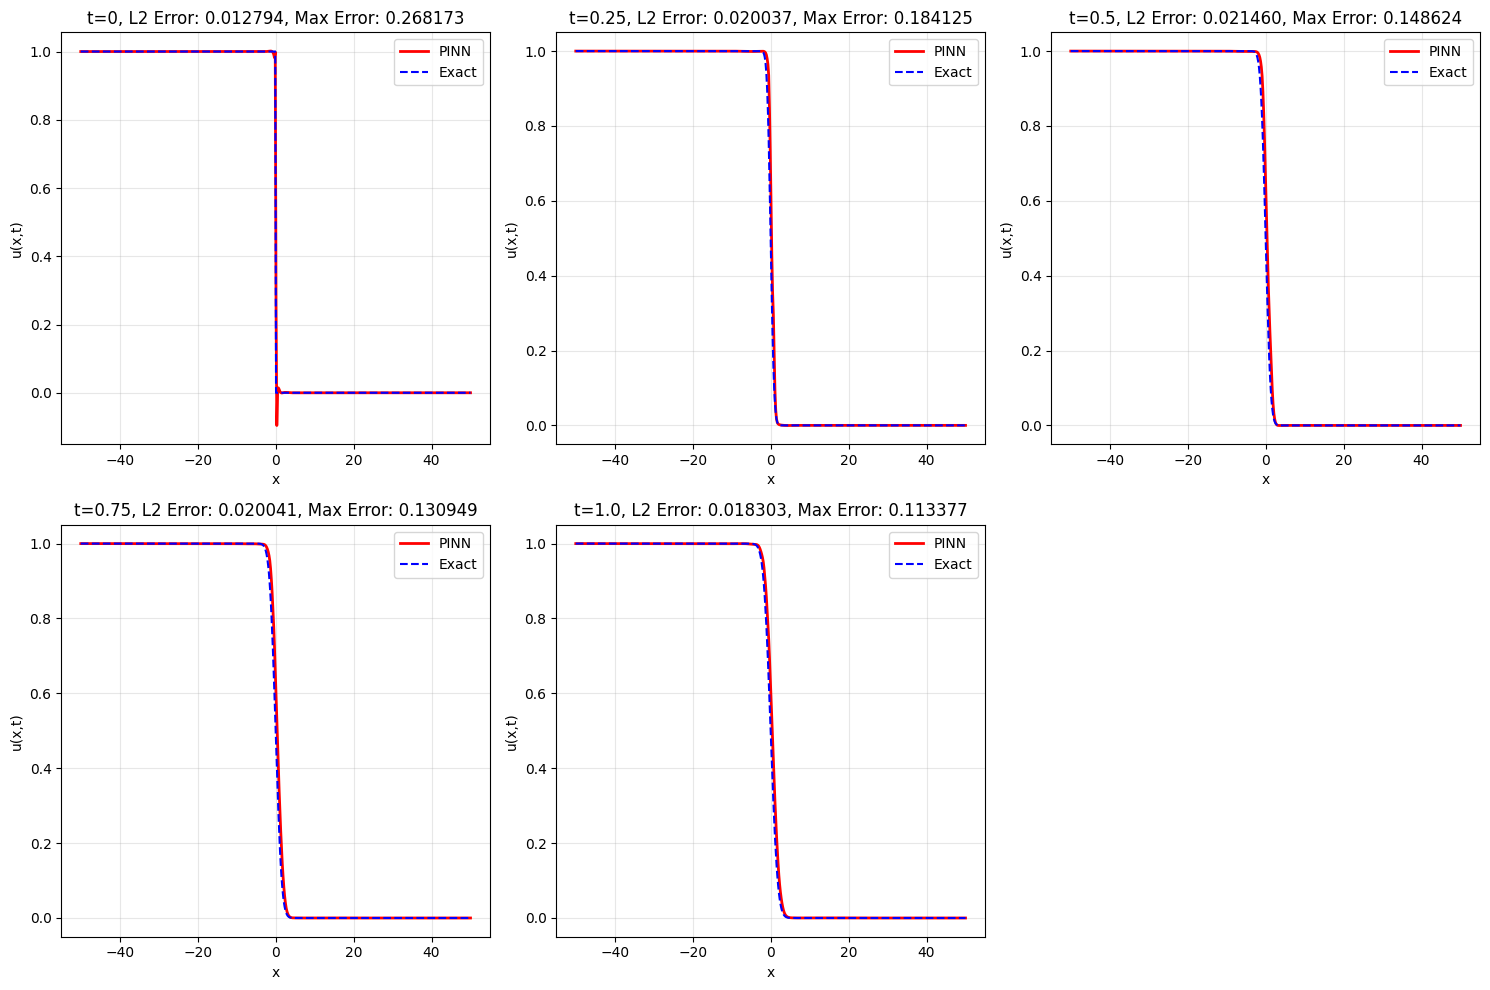

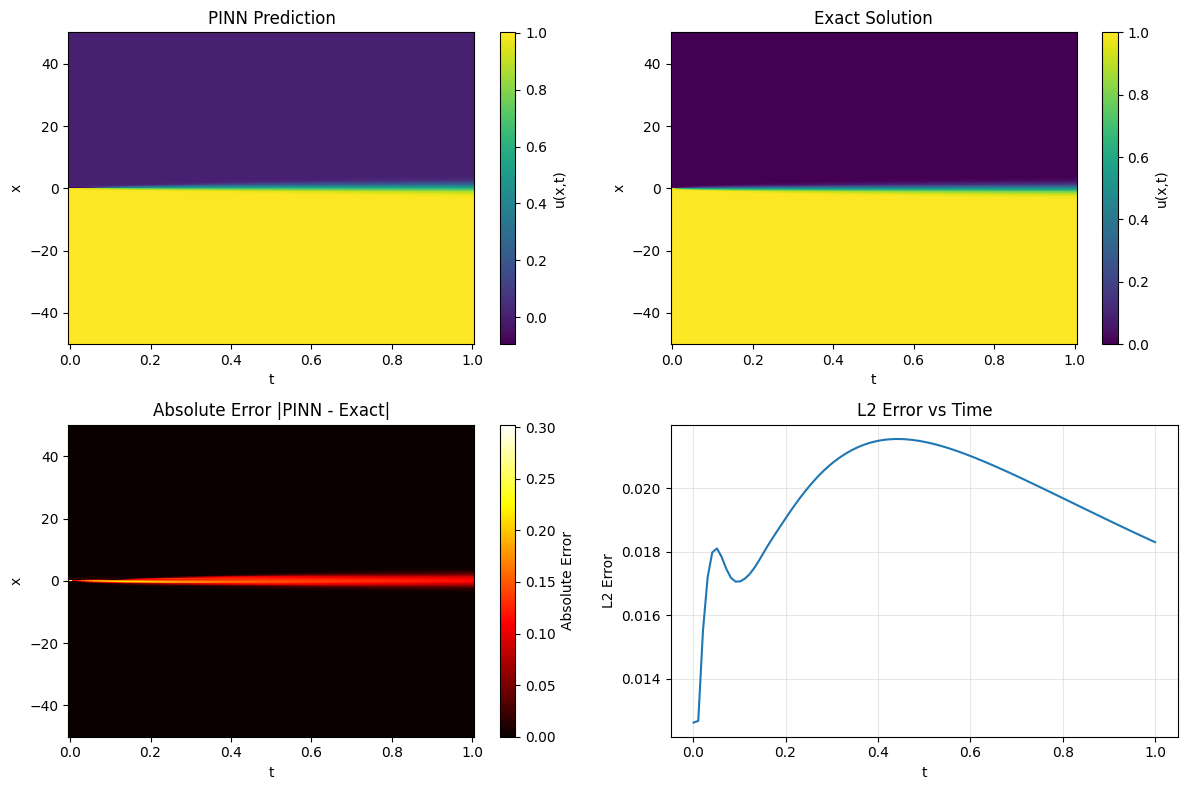


Error Metrics at Time Snapshots:
Time t=0:
  L2 Error: 0.01279383
  Max Error: 0.26817316
Time t=0.25:
  L2 Error: 0.02003708
  Max Error: 0.18412530
Time t=0.5:
  L2 Error: 0.02145965
  Max Error: 0.14862376
Time t=0.75:
  L2 Error: 0.02004071
  Max Error: 0.13094893
Time t=1.0:
  L2 Error: 0.01830283
  Max Error: 0.11337698

Overall L2 Error across entire domain: 0.01975826


In [19]:
# Load the saved model correctly
saved_data = torch.load('heat_equation discontinuous path1.pt')

# Approach 1: Extract model_state first
if 'model_state' in saved_data:
    model = PINN().to(device)
    model.load_state_dict(saved_data['model_state'])
    model.eval()
else:
    print("Different structure than expected. Keys found:", saved_data.keys())
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
import torch
from matplotlib import cm

# Fixed u_exact function
def u_exact(x_test, t_test):
    # Make sure t_test is not zero to avoid division errors
    t_safe = t_test.clone()
    t_safe[t_safe < 1e-6] = 1e-6

    # Convert to numpy for calculation
    x_np = x_test.cpu().numpy()
    t_np = t_safe.cpu().numpy()

    U_exact1 = 0.5 - 0.5 * erf(x_np  / (np.sqrt(4 * t_np)))

    u_exact_result = U_exact1

    return u_exact_result

# Set up spatial grid
nx = 500  # Number of spatial points
x_vals = torch.linspace(-50, 50, nx).view(-1, 1).to(device)  # Focusing on -20 to 20 for better visualization

# Time snapshots
time_points = [0.0, 0.25, 0.5, 0.75, 1.0]  # Using 0.001 instead of 0 to avoid division by zero
time_labels = ['t=0', 't=0.25', 't=0.5', 't=0.75', 't=1.0']

# Set up for heatmap
nt = 100  # Number of time points for heatmap
t_heatmap = torch.linspace(0.001, 1.0, nt).view(-1, 1).to(device)
x_heatmap = torch.linspace(-50, 50, nx).view(-1, 1).to(device)

# Create meshgrid for heatmap
T_mesh, X_mesh = np.meshgrid(t_heatmap.cpu().numpy(), x_heatmap.cpu().numpy())

# Initialize arrays for errors
l2_errors = []
max_errors = []

# Create figure for snapshots
plt.figure(figsize=(15, 10))

# Compute solutions at specified time snapshots
for i, t in enumerate(time_points):
    # Create tensor of same time value
    t_tensor = torch.ones_like(x_vals).to(device) * t

    # Evaluate PINN model
    with torch.no_grad():
        u_pred = model(x_vals, t_tensor).cpu().numpy()

    # Evaluate exact solution
    u_exact_vals = u_exact(x_vals, t_tensor)

    # Calculate error
    error = np.abs(u_pred - u_exact_vals)
    l2_error = np.sqrt(np.mean(error**2))
    max_error = np.max(error)

    # Store errors
    l2_errors.append(l2_error)
    max_errors.append(max_error)

    # Plot snapshot
    plt.subplot(2, 3, i+1)
    plt.plot(x_vals.cpu().numpy(), u_pred, 'red', linestyle='-', linewidth=2, label='PINN')
    plt.plot(x_vals.cpu().numpy(), u_exact_vals, 'b--', label='Exact')
    plt.title(f"{time_labels[i]}, L2 Error: {l2_error:.6f}, Max Error: {max_error:.6f}")
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig('Heat Equation discontinuous1 Snapshots.png', dpi=300)
plt.show()

# Create heatmap of error
plt.figure(figsize=(12, 8))

# Initialize arrays for heatmap
U_pred_heatmap = np.zeros((nx, nt))
U_exact_heatmap = np.zeros((nx, nt))
error_heatmap = np.zeros((nx, nt))

# Fill arrays
for j, t in enumerate(t_heatmap):
    t_tensor = torch.ones_like(x_heatmap).to(device) * t

    with torch.no_grad():
        u_pred = model(x_heatmap, t_tensor).cpu().numpy()

    u_exact_vals = u_exact(x_heatmap, t_tensor)

    U_pred_heatmap[:, j] = u_pred.flatten()
    U_exact_heatmap[:, j] = u_exact_vals.flatten()
    error_heatmap[:, j] = np.abs(u_pred.flatten() - u_exact_vals.flatten())

# Create heatmap for prediction
plt.subplot(2, 2, 1)
plt.pcolormesh(T_mesh, X_mesh, U_pred_heatmap, cmap='viridis', shading='auto')
plt.colorbar(label='u(x,t)')
plt.title('PINN Prediction')
plt.xlabel('t')
plt.ylabel('x')

# Create heatmap for exact solution
plt.subplot(2, 2, 2)
plt.pcolormesh(T_mesh, X_mesh, U_exact_heatmap, cmap='viridis', shading='auto')
plt.colorbar(label='u(x,t)')
plt.title('Exact Solution')
plt.xlabel('t')
plt.ylabel('x')

# Create heatmap for absolute error
plt.subplot(2, 2, 3)
plt.pcolormesh(T_mesh, X_mesh, error_heatmap, cmap='hot', shading='auto')
plt.colorbar(label='Absolute Error')
plt.title('Absolute Error |PINN - Exact|')
plt.xlabel('t')
plt.ylabel('x')
plt.savefig('Heat_equation_heat_map_of_exact_and_pinn_discontinuous1.png', dpi=300, bbox_inches='tight')
# Plot L2 error vs time
plt.subplot(2, 2, 4)
# Calculate L2 error at each time point
l2_errors_time = np.zeros(nt)
for j in range(nt):
    l2_errors_time[j] = np.sqrt(np.mean(error_heatmap[:, j]**2))

plt.plot(t_heatmap.cpu().numpy(), l2_errors_time)
plt.title('L2 Error vs Time')
plt.xlabel('t')
plt.ylabel('L2 Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Heat Equation error discontinuous1.png', dpi=300)
plt.show()

# Print error metrics
print("\nError Metrics at Time Snapshots:")
print("================================")
for i, t in enumerate(time_points):
    print(f"Time {time_labels[i]}:")
    print(f"  L2 Error: {l2_errors[i]:.8f}")
    print(f"  Max Error: {max_errors[i]:.8f}")

# Overall L2 error
overall_l2 = np.sqrt(np.mean(error_heatmap**2))
print("\nOverall L2 Error across entire domain: {:.8f}".format(overall_l2))

In [21]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.special import erf

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 20)
        self.hidden2 = nn.Linear(20, 20)
        self.hidden3 = nn.Linear(20, 20)
        self.output = nn.Linear(20, 1)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        h1 = torch.tanh(self.hidden1(inputs))
        h2 = torch.tanh(self.hidden2(h1))
        h3 = torch.tanh(self.hidden3(h2))
        return self.output(h3)

# Define the loss function for the PINN
def pinn_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    output = model(x, t)

    u_x = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True)[0]
    u_t = torch.autograd.grad(output, t, grad_outputs=torch.ones_like(output), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - u_xx
    return torch.mean(residual**2)

# Generate training data
def generate_training_data(N_f=1500):
    sampler = qmc.Halton(d=2, scramble=True)
    points = sampler.random(n=N_f)
    x_f = (-50 + 100 * torch.tensor(points[:, 0], dtype=torch.float32)).reshape(-1, 1).to(device)
    t_f = torch.tensor(points[:, 1], dtype=torch.float32).reshape(-1, 1).to(device)

    x_l = -50 * torch.ones(200, 1, dtype=torch.float32).to(device)
    t_rand = torch.rand(200, 1, dtype=torch.float32).to(device)

    x_r = 50 * torch.ones(200, 1, dtype=torch.float32).to(device)
    x_rand = torch.rand(300, 1, dtype=torch.float32) * 100 - 50
    t_i = torch.zeros(300, 1, dtype=torch.float32).to(device)

    return x_f, t_f, x_l, t_rand, x_r, x_rand, t_i

# Define the exact solution
def u_exact(x, t):
    return 0.5 - 0.5 * torch.erf(x / (torch.sqrt(4 * t + 1e-8)))  # Avoid division by zero

# Define the initial condition
def u0_exact(x):
    return torch.where(x > 0, torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))

# Compute the total loss
def compute_loss(model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i):
    pred_xl = model(x_l, t_rand)
    exact_xl = torch.ones_like(pred_xl)
    loss_xl = torch.mean((pred_xl - exact_xl)**2)

    pred_xr = model(x_r, t_rand)
    exact_xr = torch.zeros_like(pred_xr)
    loss_xr = torch.mean((pred_xr - exact_xr)**2)

    pred_u0 = model(x_rand, t_i)
    exact_u0 = u0_exact(x_rand)
    int_loss = torch.mean((pred_u0 - exact_u0)**2)

    pde_loss = pinn_loss(model, x_f, t_f)
    total_loss = loss_xl + loss_xr + pde_loss + int_loss

    return total_loss, pde_loss, loss_xl, int_loss

# Training loop
def train_model(model, epochs=15000):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []

    x_f, t_f, x_l, t_rand, x_r, x_rand, t_i = generate_training_data()

    for epoch in range(epochs):
        optimizer.zero_grad()
        total_loss, pde_loss, bd_loss, int_loss = compute_loss(model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i)
        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss.item():.6f}")

    return loss_history

# Calculate L2 errors
def calculate_l2_errors(model):
    x = torch.linspace(-50, 50, 1000, device=device).view(-1, 1)  # 2D tensor
    t = torch.linspace(0, 1, 1000, device=device).view(-1, 1)      # 2D tensor

    # Create 1D tensors for meshgrid
    x_1d = x.view(-1)  # Convert to 1D
    t_1d = t.view(-1)  # Convert to 1D

    # Create meshgrid
    X, T = torch.meshgrid(x_1d, t_1d, indexing='ij')  # Use 'ij' indexing for consistency

    with torch.no_grad():
        U_pred = model(X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device))
        U_exact = u_exact(X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device))

    l2_error = torch.sqrt(torch.mean((U_pred - U_exact)**2))
    max_error = torch.max(torch.abs(U_pred - U_exact))

    print(f"Global L2 Error: {l2_error.item():.4e}")
    print(f"Maximum Pointwise Error: {max_error.item():.4e}")

# Main execution
if __name__ == "__main__":
    model = PINN().to(device)
    loss_history = train_model(model)
    calculate_l2_errors(model)

    # Save the model
   # torch.save(model.state_dict(), 'pinn_heat_equation.pt')
    print("Model saved.")


Epoch 0/15000, Loss: 2.521965
Epoch 500/15000, Loss: 0.003896
Epoch 1000/15000, Loss: 0.003424
Epoch 1500/15000, Loss: 0.003085
Epoch 2000/15000, Loss: 0.002778
Epoch 2500/15000, Loss: 0.002576
Epoch 3000/15000, Loss: 0.002423
Epoch 3500/15000, Loss: 0.002284
Epoch 4000/15000, Loss: 0.002093
Epoch 4500/15000, Loss: 0.001874
Epoch 5000/15000, Loss: 0.001458
Epoch 5500/15000, Loss: 0.000908
Epoch 6000/15000, Loss: 0.000538
Epoch 6500/15000, Loss: 0.000276
Epoch 7000/15000, Loss: 0.000162
Epoch 7500/15000, Loss: 0.000114
Epoch 8000/15000, Loss: 0.000094
Epoch 8500/15000, Loss: 0.000081
Epoch 9000/15000, Loss: 0.000085
Epoch 9500/15000, Loss: 0.000065
Epoch 10000/15000, Loss: 0.000061
Epoch 10500/15000, Loss: 0.000057
Epoch 11000/15000, Loss: 0.000087
Epoch 11500/15000, Loss: 0.000157
Epoch 12000/15000, Loss: 0.000047
Epoch 12500/15000, Loss: 0.000047
Epoch 13000/15000, Loss: 0.000043
Epoch 13500/15000, Loss: 0.000041
Epoch 14000/15000, Loss: 0.000049
Epoch 14500/15000, Loss: 0.000037
Glob

In [22]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.special import erf

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom adaptive activation: scaled erf function with trainable scale factors
class GaussSigmoid(nn.Module):
    def __init__(self):
        super(GaussSigmoid, self).__init__()
    def forward(self, x):
        return torch.erf(x)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 20)
        self.hidden2 = nn.Linear(20, 20)
        self.hidden3 = nn.Linear(20, 20)
        self.output = nn.Linear(20, 1)
        # Adaptive scaling factors on erf activation per layer
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(1.0))
        self.c = nn.Parameter(torch.tensor(1.0))
        self.activation = GaussSigmoid()

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        h1 = self.activation(self.a * self.hidden1(inputs))
        h2 = self.activation(self.b * self.hidden2(h1))
        h3 = self.activation(self.c * self.hidden3(h2))
        output = self.output(h3)
        return output

def pinn_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - u_xx
    return torch.mean(residual**2)

def generate_training_data(N_f=1500):
    sampler = qmc.Halton(d=2, scramble=True)
    points = sampler.random(n=N_f)
    x_f = (-50 + 100 * torch.tensor(points[:, 0], dtype=torch.float32)).reshape(-1, 1).to(device)
    t_f = torch.tensor(points[:, 1], dtype=torch.float32).reshape(-1, 1).to(device)

    x_l = -50 * torch.ones(200, 1, dtype=torch.float32).to(device)
    t_rand = torch.rand(200, 1, dtype=torch.float32).to(device)

    x_r = 50 * torch.ones(200, 1, dtype=torch.float32).to(device)
    x_rand = torch.rand(300, 1, dtype=torch.float32) * 100 - 50
    x_rand = x_rand.to(device)
    t_i = torch.zeros(300, 1, dtype=torch.float32).to(device)

    return x_f, t_f, x_l, t_rand, x_r, x_rand, t_i

def u_exact(x, t):
    # Avoid division by zero by a small epsilon
    eps = 1e-8
    return 0.5 - 0.5 * torch.erf(x / torch.sqrt(4 * t + eps))

def u0_exact(x):
    return torch.where(x > 0, torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))

def compute_loss(model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i,
                 pde_weight=1.0, bc_weight=10.0, ic_weight=10.0):
    pred_xl = model(x_l, t_rand)
    exact_xl = torch.ones_like(pred_xl)
    loss_xl = torch.mean((pred_xl - exact_xl)**2)

    pred_xr = model(x_r, t_rand)
    exact_xr = torch.zeros_like(pred_xr)
    loss_xr = torch.mean((pred_xr - exact_xr)**2)

    pred_u0 = model(x_rand, t_i)
    exact_u0 = u0_exact(x_rand)
    int_loss = torch.mean((pred_u0 - exact_u0)**2)

    pde_loss = pinn_loss(model, x_f, t_f)
    bd_loss = loss_xl + loss_xr

    total_loss = pde_weight * pde_loss + bc_weight * bd_loss + ic_weight * int_loss

    return total_loss, pde_loss, bd_loss, int_loss

def train_model(model, epochs=15000):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, T_mult=2, eta_min=1e-5)

    x_f, t_f, x_l, t_rand, x_r, x_rand, t_i = generate_training_data()

    loss_history = []
    pde_loss_history = []
    bc_loss_history = []
    ic_loss_history = []

    best_loss = float('inf')
    best_state = None
    patience = 0
    max_patience = 10

    pde_weight = 1.0
    bc_weight = 10.0
    ic_weight = 10.0

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Dynamic weights update every 2000 epochs
        if epoch % 2000 == 0 and epoch > 0:
            bc_weight = max(1.0, bc_weight * 0.5)
            ic_weight = max(1.0, ic_weight * 0.5)
            pde_weight = min(10.0, pde_weight * 1.5)

        loss, pde_loss, bd_loss, int_loss = compute_loss(
            model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i,
            pde_weight=pde_weight, bc_weight=bc_weight, ic_weight=ic_weight)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        scheduler.step(epoch + epoch / epochs)

        loss_history.append(loss.item())
        pde_loss_history.append(pde_loss.item())
        bc_loss_history.append(bd_loss.item())
        ic_loss_history.append(int_loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = model.state_dict().copy()
            patience = 0
        else:
            patience += 1

        if patience > max_patience and epoch > 8000:
            print(f"Early stopping at epoch {epoch} (no improvement in {max_patience} epochs).")
            break

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.8e}, PDE Loss: {pde_loss:.8e}, BC Loss: {bd_loss:.8e}, IC Loss: {int_loss:.8e}")

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"Loaded best model from epoch with loss {best_loss:.8e}")

    return loss_history, pde_loss_history, bc_loss_history, ic_loss_history

def fine_tune_lbfgs(model):
    optimizer_lbfgs = optim.LBFGS(model.parameters(),
                                  lr=0.1,
                                  max_iter=20,
                                  history_size=50,
                                  tolerance_grad=1e-8,
                                  tolerance_change=1e-10,
                                  line_search_fn="strong_wolfe")

    x_f, t_f, x_l, t_rand, x_r, x_rand, t_i = generate_training_data()

    def closure():
        optimizer_lbfgs.zero_grad()
        loss, pde_loss, bd_loss, int_loss = compute_loss(
            model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i,
            pde_weight=1.0, bc_weight=1.0, ic_weight=1.0)
        loss.backward()
        return loss

    print("Starting L-BFGS fine-tuning...")
    for i in range(5):
        loss = optimizer_lbfgs.step(closure)
        print(f"L-BFGS step {i+1}, Loss: {loss.item():.8e}")

def calculate_l2_errors(model):
    x = torch.linspace(-50, 50, 1000, device=device).view(-1, 1)
    t = torch.linspace(0, 1, 1000, device=device).view(-1, 1)

    x_1d = x.view(-1)
    t_1d = t.view(-1)

    X, T = torch.meshgrid(x_1d, t_1d, indexing='ij')

    with torch.no_grad():
        U_pred = model(X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device))
        U_exact_vals = u_exact(X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device))

    l2_error = torch.sqrt(torch.mean((U_pred - U_exact_vals)**2))
    max_error = torch.max(torch.abs(U_pred - U_exact_vals))

    print(f"Global L2 Error: {l2_error.item():.4e}")
    print(f"Maximum Pointwise Error: {max_error.item():.4e}")

def main():
    model = PINN().to(device)
    start_time = time.time()

    print("Starting training with Adam optimizer...")
    loss_history, pde_loss_history, bc_loss_history, ic_loss_history = train_model(model)

    fine_tune_lbfgs(model)

    print(f"Training completed in {time.time() - start_time:.2f} seconds")

    # Save the model
    save_path = 'pinn_heat_equation_adaptive.pt'
    torch.save({'model_state': model.state_dict(),
                'activation_scales': {'a': model.a.item(),
                                      'b': model.b.item(),
                                      'c': model.c.item()}},
               save_path)
    print(f"Model saved to {save_path}")

    calculate_l2_errors(model)

if __name__ == "__main__":
    main()



Starting training with Adam optimizer...
Epoch 0/15000 - Loss: 2.63454399e+01, PDE Loss: 3.82945786e-04, BC Loss: 1.77973652e+00, IC Loss: 8.54769111e-01
Epoch 500/15000 - Loss: 2.15912536e-02, PDE Loss: 3.00108432e-03, BC Loss: 1.52431230e-05, IC Loss: 1.84377376e-03
Epoch 1000/15000 - Loss: 1.69339962e-02, PDE Loss: 2.60631507e-03, BC Loss: 2.07429829e-09, IC Loss: 1.43276609e-03
Epoch 1500/15000 - Loss: 1.00000454e-02, PDE Loss: 2.46649748e-03, BC Loss: 5.17489434e-06, IC Loss: 7.48179911e-04
Epoch 2000/15000 - Loss: 1.95860653e-03, PDE Loss: 5.49141259e-04, BC Loss: 1.86647158e-05, IC Loss: 2.08314217e-04
Epoch 2500/15000 - Loss: 9.57270153e-04, PDE Loss: 1.11480811e-04, BC Loss: 3.13875992e-09, IC Loss: 1.58006646e-04
Epoch 3000/15000 - Loss: 8.47778749e-04, PDE Loss: 9.42360057e-05, BC Loss: 4.59853738e-10, IC Loss: 1.41284487e-04
Epoch 3500/15000 - Loss: 1.26866717e-03, PDE Loss: 3.63121537e-04, BC Loss: 1.18988616e-07, IC Loss: 1.44677993e-04
Epoch 4000/15000 - Loss: 1.18356198

In [24]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from scipy.special import erf

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom adaptive activation: scaled erf function with trainable scale factors
class GaussSigmoid(nn.Module):
    def __init__(self):
        super(GaussSigmoid, self).__init__()
    def forward(self, x):
        return torch.erf(x)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 50)  # Increased width
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)  # Added more layers
        self.hidden5 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)
        # Adaptive scaling factors on erf activation per layer
        self.a = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(1.0))
        self.c = nn.Parameter(torch.tensor(1.0))
        self.activation = GaussSigmoid()

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        h1 = self.activation(self.a * self.hidden1(inputs))
        h2 = self.activation(self.b * self.hidden2(h1))
        h3 = self.activation(self.c * self.hidden3(h2))
        h4 = self.activation(self.a * self.hidden4(h3))
        h5 = self.activation(self.b * self.hidden5(h4))
        output = self.output(h5)
        return output

def pinn_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - u_xx
    return torch.mean(residual**2)

def generate_training_data(N_f=1500):
    sampler = qmc.Halton(d=2, scramble=True)
    points = sampler.random(n=N_f)
    x_f = (-50 + 100 * torch.tensor(points[:, 0], dtype=torch.float32)).reshape(-1, 1).to(device)
    t_f = torch.tensor(points[:, 1], dtype=torch.float32).reshape(-1, 1).to(device)

    x_l = -50 * torch.ones(200, 1, dtype=torch.float32).to(device)
    t_rand = torch.rand(200, 1, dtype=torch.float32).to(device)

    x_r = 50 * torch.ones(200, 1, dtype=torch.float32).to(device)
    x_rand = torch.rand(300, 1, dtype=torch.float32) * 100 - 50
    x_rand = x_rand.to(device)
    t_i = torch.zeros(300, 1, dtype=torch.float32).to(device)

    return x_f, t_f, x_l, t_rand, x_r, x_rand, t_i

def u_exact(x, t):
    eps = 1e-8
    return 0.5 - 0.5 * torch.erf(x / torch.sqrt(4 * t + eps))

def u0_exact(x):
    return torch.where(x > 0, torch.tensor(0.0, device=device), torch.tensor(1.0, device=device))

def compute_loss(model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i,
                 pde_weight=1.0, bc_weight=10.0, ic_weight=10.0):
    pred_xl = model(x_l, t_rand)
    exact_xl = torch.ones_like(pred_xl)
    loss_xl = torch.mean((pred_xl - exact_xl)**2)

    pred_xr = model(x_r, t_rand)
    exact_xr = torch.zeros_like(pred_xr)
    loss_xr = torch.mean((pred_xr - exact_xr)**2)

    pred_u0 = model(x_rand, t_i)
    exact_u0 = u0_exact(x_rand)
    int_loss = torch.mean((pred_u0 - exact_u0)**2)

    pde_loss = pinn_loss(model, x_f, t_f)
    bd_loss = loss_xl + loss_xr

    total_loss = pde_weight * pde_loss + bc_weight * bd_loss + ic_weight * int_loss

    return total_loss, pde_loss, bd_loss, int_loss

def train_model(model, epochs=20000):  # Increased epochs
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)  # Smaller learning rate
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000, T_mult=2, eta_min=1e-5)

    x_f, t_f, x_l, t_rand, x_r, x_rand, t_i = generate_training_data()

    loss_history = []
    pde_loss_history = []
    bc_loss_history = []
    ic_loss_history = []

    best_loss = float('inf')
    best_state = None
    patience = 0
    max_patience = 10

    pde_weight = 1.0
    bc_weight = 10.0
    ic_weight = 10.0

    for epoch in range(epochs):
        optimizer.zero_grad()

        if epoch % 2000 == 0 and epoch > 0:
            bc_weight = max(1.0, bc_weight * 0.5)
            ic_weight = max(1.0, ic_weight * 0.5)
            pde_weight = min(10.0, pde_weight * 1.5)

        loss, pde_loss, bd_loss, int_loss = compute_loss(
            model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i,
            pde_weight=pde_weight, bc_weight=bc_weight, ic_weight=ic_weight)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        scheduler.step(epoch + epoch / epochs)

        loss_history.append(loss.item())
        pde_loss_history.append(pde_loss.item())
        bc_loss_history.append(bd_loss.item())
        ic_loss_history.append(int_loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = model.state_dict().copy()
            patience = 0
        else:
            patience += 1

        if patience > max_patience and epoch > 8000:
            print(f"Early stopping at epoch {epoch} (no improvement in {max_patience} epochs).")
            break

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.8e}, PDE Loss: {pde_loss:.8e}, BC Loss: {bd_loss:.8e}, IC Loss: {int_loss:.8e}")

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"Loaded best model from epoch with loss {best_loss:.8e}")

    return loss_history, pde_loss_history, bc_loss_history, ic_loss_history

def fine_tune_lbfgs(model):
    optimizer_lbfgs = optim.LBFGS(model.parameters(),
                                  lr=0.1,
                                  max_iter=20,
                                  history_size=50,
                                  tolerance_grad=1e-8,
                                  tolerance_change=1e-10,
                                  line_search_fn="strong_wolfe")

    x_f, t_f, x_l, t_rand, x_r, x_rand, t_i = generate_training_data()

    def closure():
        optimizer_lbfgs.zero_grad()
        loss, pde_loss, bd_loss, int_loss = compute_loss(
            model, x_f, t_f, x_l, t_rand, x_r, x_rand, t_i,
            pde_weight=1.0, bc_weight=1.0, ic_weight=1.0)
        loss.backward()
        return loss

    print("Starting L-BFGS fine-tuning...")
    for i in range(5):
        loss = optimizer_lbfgs.step(closure)
        print(f"L-BFGS step {i+1}, Loss: {loss.item():.8e}")

def calculate_l2_errors(model):
    x = torch.linspace(-50, 50, 1000, device=device).view(-1, 1)
    t = torch.linspace(0, 1, 1000, device=device).view(-1, 1)

    x_1d = x.view(-1)
    t_1d = t.view(-1)

    X, T = torch.meshgrid(x_1d, t_1d, indexing='ij')

    with torch.no_grad():
        U_pred = model(X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device))
        U_exact_vals = u_exact(X.reshape(-1, 1).to(device), T.reshape(-1, 1).to(device))

    l2_error = torch.sqrt(torch.mean((U_pred - U_exact_vals)**2))
    max_error = torch.max(torch.abs(U_pred - U_exact_vals))

    print(f"Global L2 Error: {l2_error.item():.4e}")
    print(f"Maximum Pointwise Error: {max_error.item():.4e}")

def main():
    model = PINN().to(device)
    start_time = time.time()

    print("Starting training with Adam optimizer...")
    loss_history, pde_loss_history, bc_loss_history, ic_loss_history = train_model(model)

    fine_tune_lbfgs(model)

    print(f"Training completed in {time.time() - start_time:.2f} seconds")

    # Save the model
    save_path = 'pinn_heat_equation_adaptive.pt'
    #torch.save({'model_state': model.state_dict(),
               # 'activation_scales': {'a': model.a.item(),
                                     # 'b': model.b.item(),
                                     # 'c': model.c.item()}},
              # save_path)
    #print(f"Model saved to {save_path}")

    calculate_l2_errors(model)

if __name__ == "__main__":
    main()


Starting training with Adam optimizer...
Epoch 0/20000 - Loss: 1.56692753e+01, PDE Loss: 2.15564156e-04, BC Loss: 1.06216311e+00, IC Loss: 5.04742861e-01
Epoch 500/20000 - Loss: 2.15873476e-02, PDE Loss: 4.21093870e-03, BC Loss: 1.06348944e-06, IC Loss: 1.73657737e-03
Epoch 1000/20000 - Loss: 1.62876528e-02, PDE Loss: 3.32629075e-03, BC Loss: 4.52500153e-08, IC Loss: 1.29609089e-03
Epoch 1500/20000 - Loss: 1.35898935e-02, PDE Loss: 3.72181251e-03, BC Loss: 4.64106688e-06, IC Loss: 9.82166966e-04
Epoch 2000/20000 - Loss: 1.06486613e-02, PDE Loss: 3.98022775e-03, BC Loss: 1.06302745e-04, IC Loss: 8.29361146e-04
Epoch 2500/20000 - Loss: 6.82758773e-03, PDE Loss: 1.26392080e-03, BC Loss: 1.40468686e-08, IC Loss: 9.86327184e-04
Epoch 3000/20000 - Loss: 5.78379212e-03, PDE Loss: 1.03485596e-03, BC Loss: 1.88771097e-08, IC Loss: 8.46282812e-04
Epoch 3500/20000 - Loss: 5.01134153e-03, PDE Loss: 8.09415418e-04, BC Loss: 9.04686895e-05, IC Loss: 6.68975059e-04
Epoch 4000/20000 - Loss: 2.08688620